In [1]:
import torch
import os
import shap
import pandas as pd
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import seaborn as sn

## load dataset

In [2]:
COLNAME = ['station_id', 'year', 'month', 'day', 'hour', 'ELEV',
        'WDIR', 'WDSD', 'TEMP', 'HUMD', 'PRES',
        'H_24R', 'ALLSKY_SFC_SW_DWN', 'ALLSKY_SFC_SW_DNI',
        'ALLSKY_SFC_SW_DIFF', 'SZA']

In [3]:
csv_data = [f for f in os.listdir('./data') if '.csv' in f]

In [4]:
np_data = {f.split('_')[0]: pd.read_csv(f'./data/{f}').to_numpy() for f in csv_data}

Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.


In [5]:
with open('./data/new_instance_data.pkl', 'rb') as pkl_f:
    instance_data = pkl.load(pkl_f)

## observation and analysis func

In [6]:
def dayli_time_period(t):
    f = -np.cos((2 * np.pi  * t ) / 24)
    return f if f > 0 else 0

def new_dayli_time_period(t, m=12, std=2, scale=1):
    return scale * np.exp(-(t-m)**2/(2*std**2)) 

# def month_time_period(m):
#     f = -np.cos((2 * np.pi  * t ) / 12)
#     return f

def violin_plot_perhr(dot_data, save_name=''):
    x_ticks = np.arange(1, 25)
    y_ticks = np.arange(0, 1001, 200)
    plt.figure(figsize=((36, 8)))
    plt.style.use('seaborn')
    for idx, (season, data) in enumerate(dot_data.items()):
        if not len(data[0]) > 1:
            data = 24 * [[0]]
        plt.subplot(2,2,idx+1)
        plt.title(season, fontsize=18)
        plt.violinplot(data, showmedians=True)
        plt.xticks(x_ticks, fontsize=14)
        plt.yticks(y_ticks, fontsize=14)
        plt.ylabel('GHI')
        plt.tight_layout()
    if save_name:
        plt.savefig(f'./figure/{save_name}.jpg', dpi=200)
        
def sid_data_integrated(year, sid_data_index, target_col_index):
    month_trans = {
    12: '12.1.2', 1: '12.1.2', 2: '12.1.2',
    3: '3.4.5', 4: '3.4.5', 5: '3.4.5',
    6: '6.7.8', 7: '6.7.8', 8: '6.7.8',
    9: '9.10.11', 10: '9.10.11', 11: '9.10.11',
    }
    season_c = {'12.1.2': [[] for i in range(24)],
                '3.4.5': [[] for i in range(24)],
                '6.7.8': [[] for i in range(24)],
                '9.10.11': [[] for i in range(24)]}
    s, e = sid_data_index
    for row in np_data[str(year)][s: e]:
        m = int(row[2])
        h = int(row[4])
        season = month_trans[m]
        target = float(row[target_col_index] if not np.isnan(row[target_col_index]) else 0)
        season_c[season][h].append(target)
    return season_c

def get_sid(instance_data):
    uni_sid = []
    for sid, (start_idx, end_idx) in instance_data.items():
        uni_sid.append(sid)
    return list(uni_sid)

def corr_ploting(data, save_name='', row=4, col=4):
    assert len(data) == row * col, 'length of data should be same as row x col'
    plt.figure(figsize=((row*8, col*6)))
    plt.style.use('seaborn')
    for idx, (_sid, _d) in enumerate(data.items()):
        plt.subplot(row, col, idx+1)
        plt.title(_sid, fontsize=18)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        sn.heatmap(_d, cmap='YlGnBu', square=True, annot=True, annot_kws={"fontsize":14})
    plt.tight_layout()
    if save_name:
        plt.savefig(f'./figure/{save_name}.jpg', dpi=200)
        
def get_sid_data_index(instance_data, sid):
    sid_idx = instance_data[sid]
    return sid_idx

def get_corr_matrix(year, sid_data_idx, selected_col, needs_pd=False, corr_method='pearson'):
    s, e = sid_data_idx
    sid_data = pd.DataFrame(np_data[str(year)][np.arange(s,e)], columns=COLNAME)[selected_col]
    sid_data['ALLSKY_SFC_SW_DWN'] = sid_data['ALLSKY_SFC_SW_DWN'].fillna(0)
    for c in ['WDIR', 'WDSD', 'TEMP', 'HUMD', 'PRES']:
        sid_data = sid_data[sid_data[c] != -9999.0]
    for c in selected_col:
        sid_data[c] = pd.to_numeric(sid_data[c])
    sid_data.rename(columns = {'ALLSKY_SFC_SW_DWN':'GHI'}, inplace = True)

    sid_data['hour'] = sid_data['hour'].apply(dayli_time_period)
#     sid_data['month'] = sid_data['month'].apply(month_time_period)
    
    sid_data_cor = sid_data.corr(method=corr_method)
    if not needs_pd:
        return sid_data_cor
    else:
        return sid_data, sid_data_cor

## analyze by drawing related data at station

In [7]:
year = 2017
target_col = 12
selected_col = ['month', 'hour', 'WDIR', 'WDSD', 'TEMP', 'HUMD', 'PRES', 'ALLSKY_SFC_SW_DWN']
# selected_col = ['WDIR', 'WDSD', 'TEMP', 'HUMD', 'PRES', 'ALLSKY_SFC_SW_DWN']

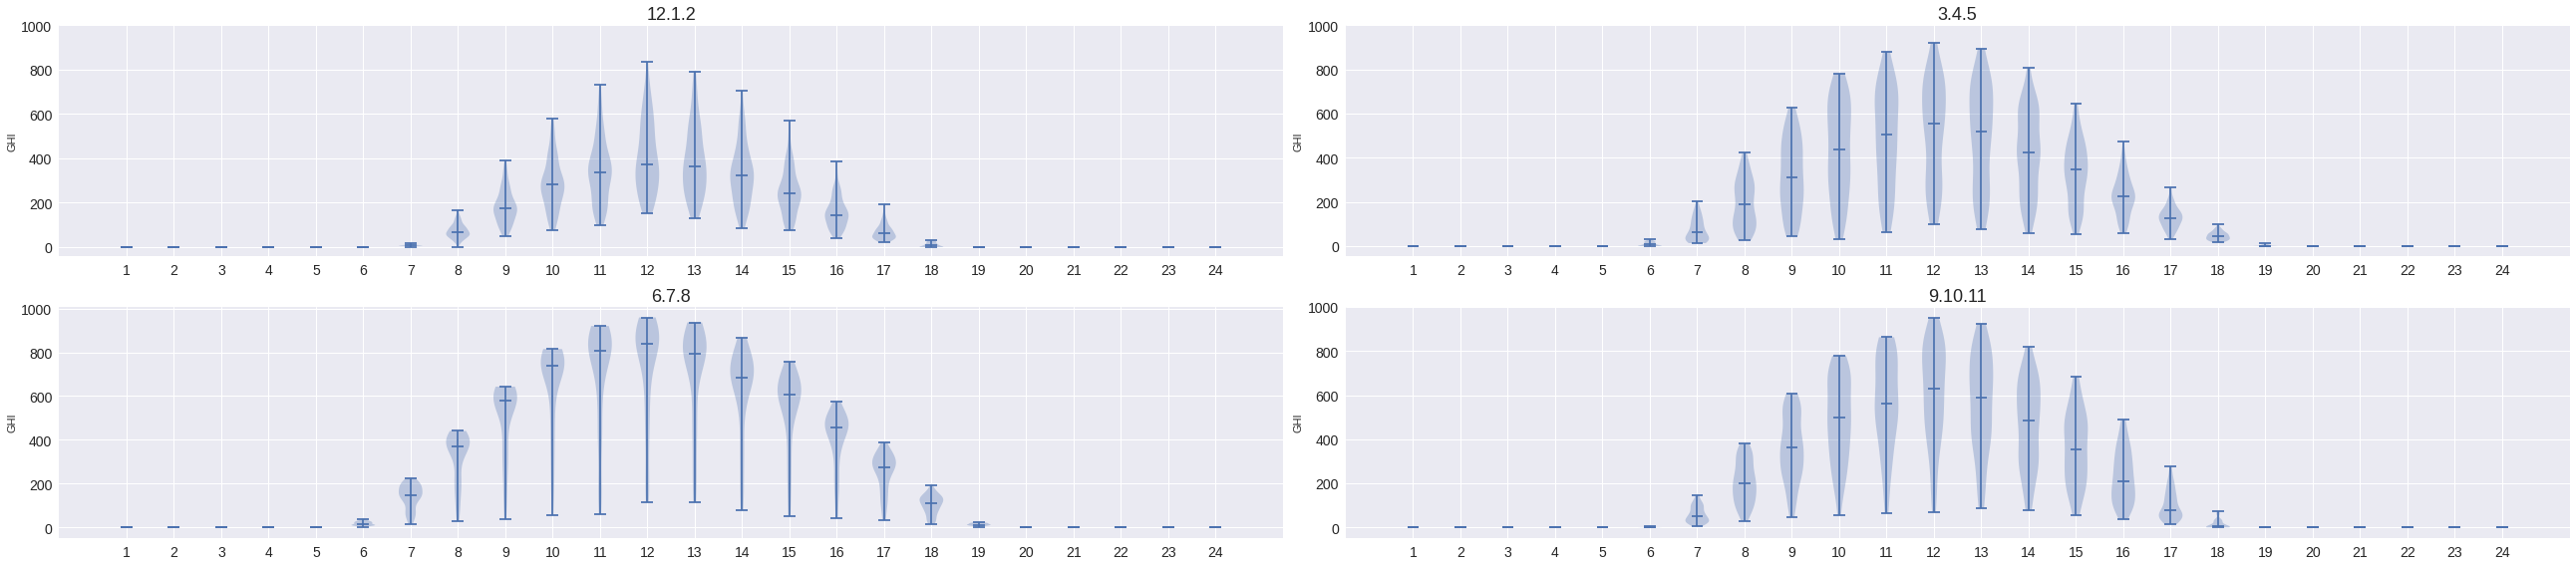

In [8]:
sid_set = get_sid(instance_data[year])
sid_data_idx = get_sid_data_index(instance_data[year], 'C0T9M0')
season_c = sid_data_integrated(year, sid_data_idx, target_col)
violin_plot_perhr(season_c, save_name='sid_466950_season_GHI_perhour')

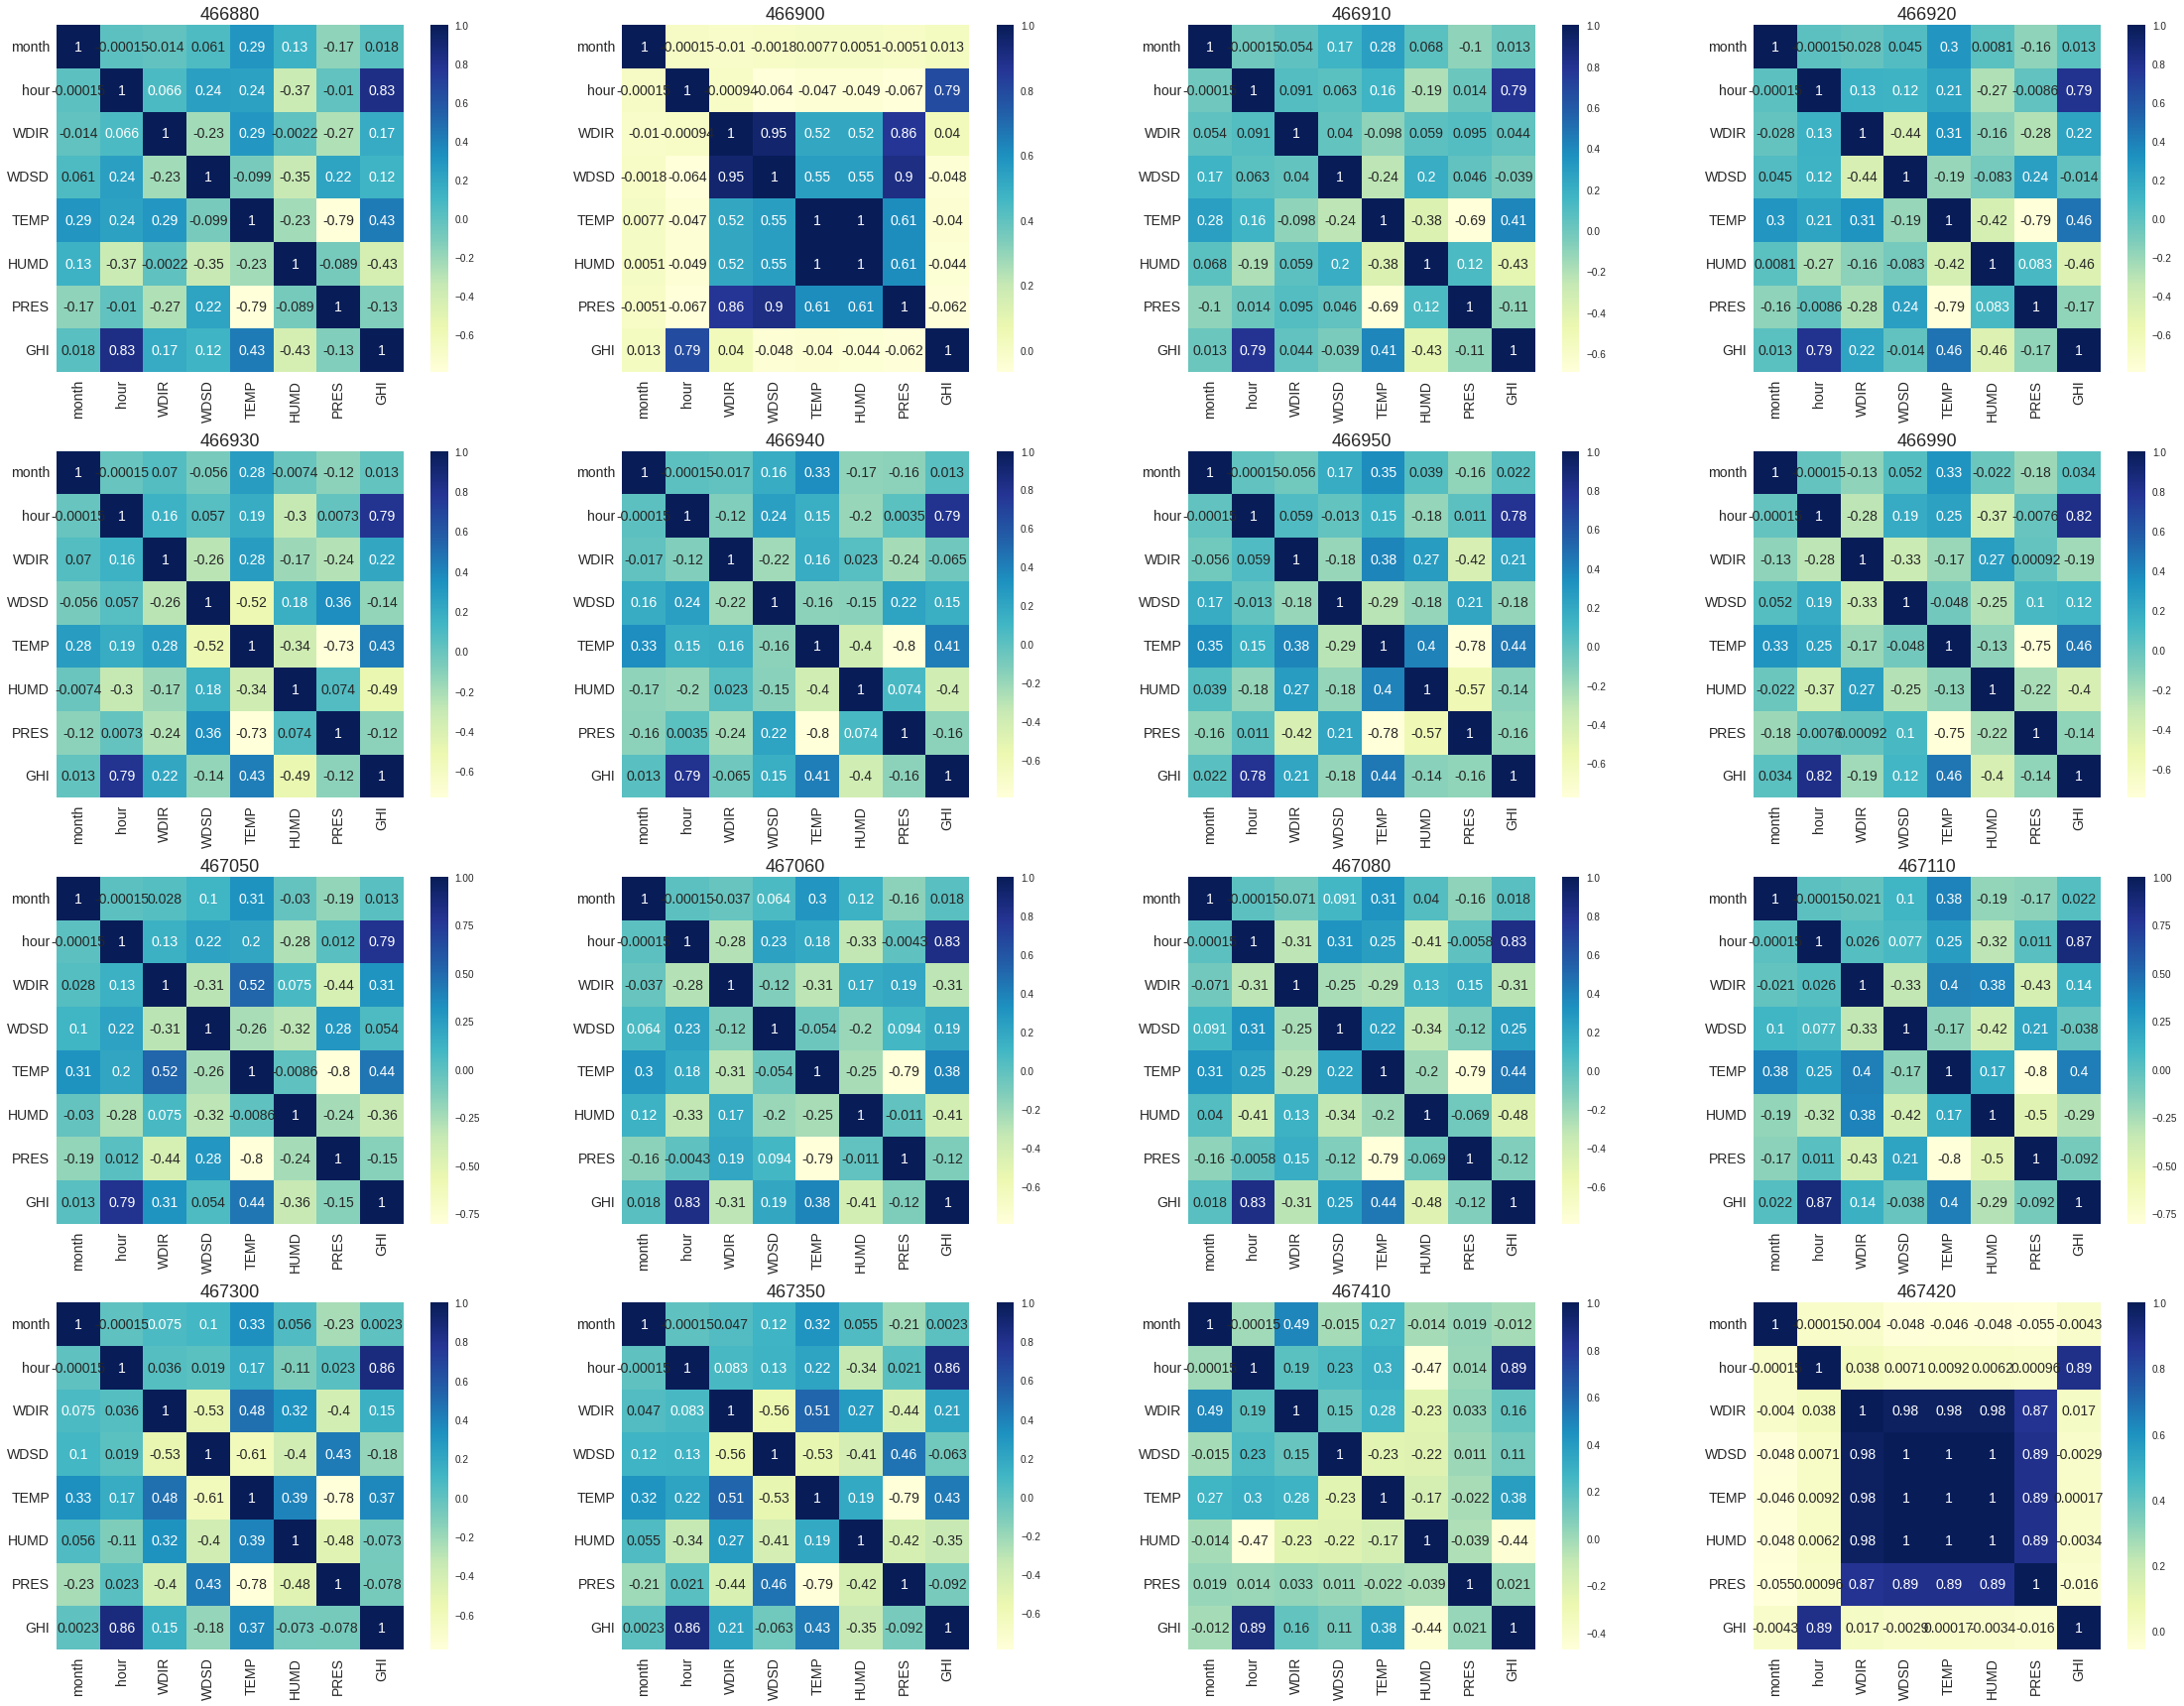

In [9]:
samples_sid_data_idx = {sid: get_sid_data_index(instance_data[year], sid) for sid in sid_set[:16]}
samples_corr_m = {sid: get_corr_matrix(2017, data_idx, selected_col, corr_method='pearson') for sid, data_idx in samples_sid_data_idx.items()}
corr_ploting(samples_corr_m, save_name='20220524_corr_pearson')

## scikit-learning model and evaluation

In [10]:
import xgboost as xgb
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.preprocessing import MinMaxScaler

## ML model declared

In [72]:
def get_model_group():
    ml_models = [
        ('LR', LinearRegression(n_jobs=8)),
        ('RF40', RandomForestRegressor(n_estimators=40, n_jobs=8, random_state=42,)),
#         ('RF60', RandomForestRegressor(n_estimators=60, n_jobs=8)),
#         ('RF80', RandomForestRegressor(n_estimators=80, n_jobs=8)),
        ("XGB40", xgb.XGBRegressor(objective="reg:squarederror", n_estimators=40, random_state=42, tree_method='gpu_hist', gpu_id=0)),
#         ("XGB60", xgb.XGBRegressor(objective="reg:squarederror", n_estimators=60, random_state=42, tree_method='gpu_hist', gpu_id=0)),
#         ("XGB200", xgb.XGBRegressor(objective="reg:squarederror", n_estimators=200, random_state=42, tree_method='gpu_hist', gpu_id=0)),
    ]
    return ml_models

## data split

In [73]:
def get_data(year, selected_col, shift=0, export_pd=False):
    pd_data = pd.DataFrame(np_data[str(year)], columns=COLNAME)[selected_col]
    pd_data['ALLSKY_SFC_SW_DWN'] = pd_data['ALLSKY_SFC_SW_DWN'].fillna(0)
    pd_data['HUMD'] = pd_data['HUMD'].fillna(-1)
    
    for c in ['WDIR', 'WDSD', 'TEMP', 'HUMD', 'PRES']:
        pd_data = pd_data[pd_data[c] != -9999.0]
    for c in selected_col:
        pd_data[c] = pd.to_numeric(pd_data[c])
    
#     pd_data['hour'] = pd_data['hour'].apply(new_dayli_time_period)
#     pd_data['hour'] = pd_data['hour'].apply(dayli_time_period)

    data = pd_data.to_numpy()
    idx = np.arange(data.shape[0]-1)
#     np.random.shuffle(idx)
    X = data[idx, :-1]
    Y = data[idx, -1]
    if not export_pd:
        return X, Y
    else:
        return X, Y, pd_data

In [74]:
train_X, train_Y = get_data(2017, selected_col, export_pd=False)
test_X, test_Y = get_data(2018, selected_col, export_pd=False)

In [75]:
strain_idx, etrain_idx = instance_data[2017][466880]
stest_idx, etest_idx = instance_data[2018]['466880']
# train_X = train_X[strain_idx:etrain_idx]
# train_Y = train_Y[strain_idx:etrain_idx]
test_X = test_X[stest_idx:etest_idx]
test_Y = test_Y[stest_idx:etest_idx]

In [76]:
y_scaler = MinMaxScaler(feature_range=(0, 1))
feature_scaler = MinMaxScaler(feature_range=(-1,1))
fscaler = feature_scaler.fit(train_X)
yscaler = y_scaler.fit(train_Y.reshape(-1,1))

In [77]:
train_scaled = feature_scaler.transform(train_X)
test_scaled = feature_scaler.transform(test_X)
train_y_scaled = yscaler.transform(train_Y.reshape(-1,1))
test_y_scaled = yscaler.transform(test_Y.reshape(-1,1))

In [78]:
ml_models = get_model_group()
results = []
for m in ml_models:
    name, model = m
    print(f'{name} training start!')
    model.fit(train_scaled, train_y_scaled.reshape(-1,))
    print(f'{name} trianing finished')
    print(f'prediction and evalution')
    pred = model.predict(test_scaled)
    results.append((name, pred))
    err = mean_squared_error(test_y_scaled.reshape(-1,), pred)
    print(f'error: {err}')


2022/05/25 18:43:47 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '98679c67c15747f7b4ed7b25a57c3c3b', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


LR training start!


2022/05/25 18:43:47 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '53e53fc01d8a40edbdcff5d3e3d639c9', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


LR trianing finished
prediction and evalution
error: 0.034777533094421414
RF40 training start!


2022/05/25 18:44:49 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '5295d5484c3c4c5586255c251e5f1d16', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow


RF40 trianing finished
prediction and evalution
error: 0.0037109233444508733
XGB40 training start!
XGB40 trianing finished
prediction and evalution
error: 0.003070619944486307


In [79]:
inverse_trans_result = []
y_true = yscaler.inverse_transform(test_y_scaled.reshape(-1, 1)).reshape(-1, )
for info in results:
    name, _pred = info
    y_pred = yscaler.inverse_transform(_pred.reshape(-1, 1)).reshape(-1, )
    r2 = r2_score(y_true, y_pred)
    inverse_trans_result.append((name, (r2, y_pred)))

In [80]:
inverse_trans_result.append(('LSTM stride 3', (r2_score(test_Y, denorm_pred_y), denorm_pred_y)))

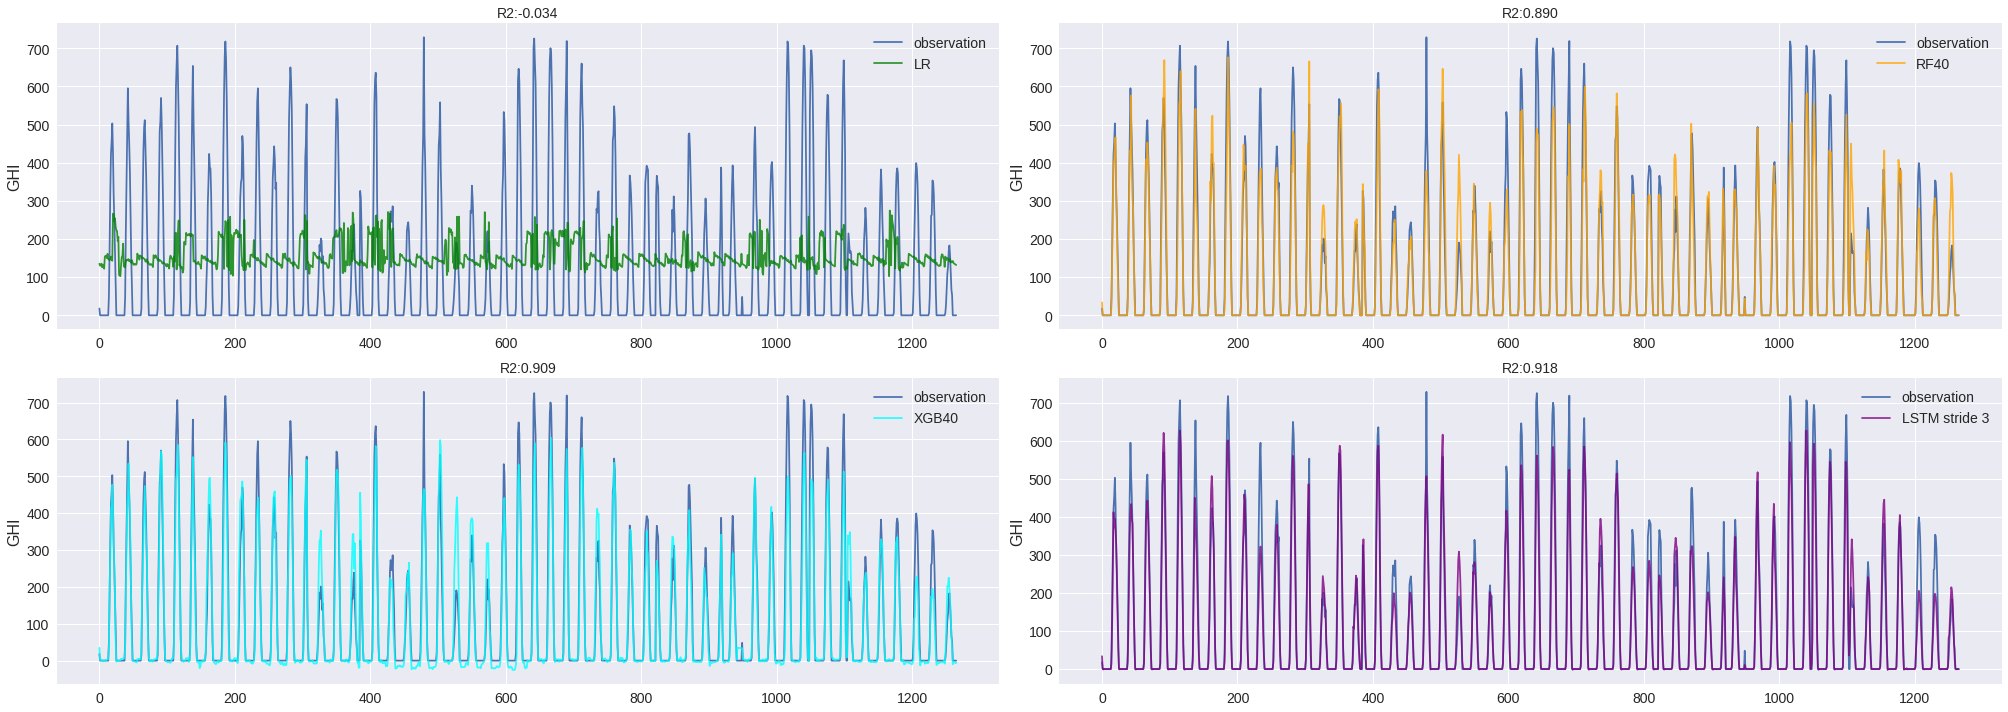

In [81]:
plt.figure(figsize=(28, 10))
c = ['g', 'orange', 'cyan', 'purple']
for i, mpred in enumerate(inverse_trans_result):
    plt.subplot(2,2,i+1)
    plt.plot(y_true, label='observation')
    name, r = mpred
    plt.plot(r[1], label=f'{name}', alpha=0.8, color=c[i])
    plt.ylabel('GHI', fontsize=16)
    plt.legend(loc='upper right', fontsize=14)
    plt.title(f'R2:{r[0]:.3f}', fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig('./figure/20220525_ML_model_result_NoTrans.jpg', dpi=300)

## NN model

In [13]:
from torchsummary import summary
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms as T

### add. info configuration

In [14]:
out_station = ['C0W170', '467990', 'C0W110', '466950', '468100', '469020']
max_lat, min_lat = 25.4, 21.8
max_lon, min_lon = 122.05, 119.0

### data process

In [15]:
def get_sid_with_defect_data(year, selected_col, chk_cols=['WDIR', 'WDSD', 'TEMP', 'HUMD', 'PRES']):
    pd_data = pd.DataFrame(np_data[str(year)], columns=COLNAME)[selected_col]    
    for c in chk_cols:
        pd_data = pd_data[pd_data[c] == -9999.0]
    return list(pd_data['station_id'].unique())

def get_year_data(year, selected_col):
    pd_data = pd.DataFrame(np_data[str(year)], columns=COLNAME)[selected_col]
    pd_data['ALLSKY_SFC_SW_DWN'] = pd_data['ALLSKY_SFC_SW_DWN'].fillna(0)
    pd_data['HUMD'] = pd_data['HUMD'].fillna(-1)
    
    for c in selected_col:
        if c != 'station_id':
            pd_data[c] = pd.to_numeric(pd_data[c])
            
#     pd_data['hour'] = pd_data['hour'].apply(dayli_time_period)
    return pd_data

def get_station_lat_lon(station_info_path):
    sid_info = {}
    station_info = pd.read_csv(station_info_path)
    for i, row in station_info.iterrows():
        sid_info.update({row['station_id']: [
            row['latitude'], row['longitude']]})
    return sid_info

def instance_data_wrapped(instance_data, wrapped_name, wrapped_info, excepted_station):
    new_instance_data = {}
    for year, station_data in instance_data.items():
        new_instance_data[year] = {}
        for station_id, slice_idx in station_data.items():
            if not str(station_id) in excepted_station[year]:
                start_idx, end_idx = slice_idx
                lat, lon = wrapped_info[str(station_id)]
                new_instance_data[year][str(station_id)] = {
                    'data_slice': (start_idx, end_idx), wrapped_name: (lat, lon)}
    return new_instance_data

In [16]:
class WeatherData(Dataset):
    def __init__(self, data, instance_info, augmentation, preprocessing, lag=3):
        """
        data: (dict[year, np.data])
        instance_info: (dict[year, dict[sid, dict[data_slice, (int, int)]])
        """
        super(WeatherData, self).__init__()
        self.data = data
        self.instance = instance_info
        self.lag = lag
        self.preprocessing = preprocessing
        self.augmentation = augmentation
        self.index_dataset = []
        self.dataset_gen()
        
    def dataset_gen(self):
        for year, _ in self.data.items():
            for sid, info in self.instance[year].items():
                start_idx, end_idx = info['data_slice']
                end_idx_with_lag = (end_idx - self.lag + 1)
                _tmp_idx = [(year, i) for i in range(start_idx, end_idx_with_lag + 1)]
                self.index_dataset += _tmp_idx
        
    def __len__(self):
        return len(self.index_dataset)
    
    def __getitem__(self, index):
        _year, _idx = self.index_dataset[index]
        d = self.data[_year][_idx: _idx + self.lag]
        # shape is lag x features
        x, y = d[:, :-1], d[:, -1]
        x = self.augmentation(x)
        y = self.preprocessing(y)
        return x, y

In [85]:
t=np.random.random((3, 5))
y=np.random.random((3, 1))

In [84]:
t

array([[0.55154934, 0.73850222, 0.11623243, 0.57068171, 0.85335157],
       [0.12551239, 0.3573035 , 0.55290933, 0.89982744, 0.84741058],
       [0.70562444, 0.670335  , 0.09997508, 0.97879717, 0.58751398]])

In [86]:
y

array([[0.70190448],
       [0.27893668],
       [0.60690116]])

In [34]:
def masked_lag(t, low_bound=-1):
    def wrapped(x):
        if t == 0:
            return x
        else:
            x[t:, :] = low_bound
            return x
    return wrapped

def train_augmentation(scaler, instance_mask):
    def wrapped(x):
        x[:, 0] = x[:, 0].astype(np.int32)
        x[:, 1] = x[:, 1].astype(np.int32)
#         x[:, 2:] = scaler.transform(x[:, 2:])
#         x[:, 2:] = (x[:, 2:] - scaler[:, :, 0]) / scaler[:, :, 1]
        x[:, 2:] = instance_mask(x[:, 2:])
        x = torch.tensor(x).float()
        return x
    return wrapped

def val_augmentation(scaler):
    def wrapped(x):
        x[:, 0] = x[:, 0].astype(np.int32)
        x[:, 1] = x[:, 1].astype(np.int32)
#         x[:, 2:] = scaler.transform(x[:, 2:])
#         x[:, 2:] = (x[:, 2:] - scaler[:, :, 0]) / scaler[:, :, 1]
        x = torch.tensor(x).float()
        return x
    return wrapped

def preprocessing(scaler):
    def wrapped(y):
        y = scaler.transform(y.reshape(-1, 1)).reshape(-1, )
#         y = (y-scaler[0]) / scaler[1]
        y = torch.tensor(y).float()
        return y
    return wrapped

def normalized(x, m, std):
    return (x-m) / std

def denormalized(x, m, std):
    return (x * std) + m

In [35]:
_selected_col = ['station_id', 'month', 'hour', 'WDIR', 'WDSD', 'TEMP', 'HUMD', 'PRES', 'ALLSKY_SFC_SW_DWN']
defect_station = {y:get_sid_with_defect_data(y, _selected_col) + out_station for y in range(2017, 2022)}
station_info = get_station_lat_lon('./data/weather_station.csv')
new_instance = instance_data_wrapped(instance_data, 'position', station_info, defect_station)

In [36]:
LAG = 3
x, y = get_data(2017, selected_col)
YSCALER = MinMaxScaler(feature_range=(0, 1))
XSCALER = MinMaxScaler(feature_range=(-1, 1))
xscaler = XSCALER.fit(x[:, 2: ])
# xscaler = np.array([[x[:, i].mean(), x[:,i].std()] for i in range(2, 7)])[np.newaxis,:,:]
yscaler = YSCALER.fit(y.reshape(-1, 1))
# yscaler = np.array([y.mean(), y.std()])
INSTANCE_MASK = T.RandomChoice([masked_lag(t) for t in range(LAG)])

In [37]:
train_data = {i: get_year_data(i, selected_col).to_numpy() for i in range(2017, 2018)}
test_data = {i: get_year_data(i, selected_col).to_numpy() for i in range(2018, 2019)}

In [38]:
train_dataset = WeatherData(train_data, new_instance, train_augmentation(xscaler, INSTANCE_MASK), preprocessing(yscaler))
test_dataset = WeatherData(test_data, new_instance, val_augmentation(xscaler), preprocessing(yscaler))
train_loader = DataLoader(train_dataset, batch_size=1024, num_workers=8, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=1024, num_workers=8,)

In [39]:
x, y = next(iter(val_loader))

In [40]:
class TimeSeriesModel(torch.nn.Module):
    def __init__(self, input_size, output_size, hidden_size, layers, batch_first=True,
                 biD=False, dropout=0, emb_size=20):
        super(TimeSeriesModel, self).__init__()
        self.month_emb = torch.nn.Embedding(13, emb_size, )
        self.hour_emb = torch.nn.Embedding(25, emb_size)
        self.proj = torch.nn.Sequential(
            torch.nn.Linear(input_size, hidden_size, bias=True),
            torch.nn.LayerNorm(hidden_size),
            torch.nn.ReLU()
        )
        self.lstm = torch.nn.LSTM(hidden_size, hidden_size * 2, layers,
                                  bidirectional=biD, dropout=dropout)
        self.pred_layer = torch.nn.Linear(hidden_size * 4, output_size)
        
    def forward(self, x):
        month_emb = self.month_emb(x[:, :, 0].int())
        hour_emb = self.hour_emb(x[:, :, 1].int())
        
        _x = self.proj(x[:, :, 2:].float())
        x = _x + month_emb + hour_emb
        x = x.permute((1, 0, 2))
        # from batch, seq, features -> seq, batch, features

        hidden_x, (last_h, last_c) = self.lstm(x)
        pred_y = self.pred_layer(hidden_x)
        pred_y = pred_y.permute((1, 0, 2))
        return pred_y.squeeze()

In [41]:
nn_model = TimeSeriesModel(5, 1, 32, 4, biD=True, dropout=0.4, emb_size=32)

In [42]:
pred_y = nn_model(x)

In [43]:
import sys
sys.path.append('../iPKM_Trademark_vs/notebook.test/sphinx/')
from sci_sphinx.utils.loss import LambdaLoss, CompositeLoss
from sci_sphinx.utils.metric import LambdaMetric, CompositeMetric
from sci_sphinx.utils.learning import Runner, Trainer

In [44]:
def mse(y_pred, y_true, device='cuda'):
    err = torch.nn.functional.mse_loss(y_pred, y_true)
    return err

def r2(y_pred, y_true):
    y_pred = torch.flatten(y_pred).detach().cpu().numpy()
    y_true = torch.flatten(y_true).detach().cpu().numpy()
    r2 = r2_score(y_true, y_pred)
    return r2

In [45]:
r2(pred_y, y)

-1.075158450844309

In [46]:
mse_loss = LambdaLoss(mse, name='mse_loss', tracing_target=False)
mse_m = LambdaMetric(r2, name='r2', tracing_target=True)

In [47]:
optimizer = torch.optim.AdamW(nn_model.parameters(), lr=3e-4, betas=(0.9, 0.999), eps=1e-8, weight_decay=0.05)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 300, )

In [48]:
runner = Runner(nn_model, loss_funcs=mse_loss, 
                metrics=mse_m, optimizer=optimizer, lr_scheduler=lr_scheduler)

[2022-05-25 14:06:52.242] [INFO] - The Runner has been initialized, the tracing marker is r2 and the target is trying to find the maximum value.


In [49]:
trainer = Trainer('solar forecasting', max_epochs=200, step_warmup4epoch=5, recording_interval=300, accelerator='gpu', devices=1)

[2022-05-25 14:06:52.248] [INFO] - GPU available: True, used: True
[2022-05-25 14:06:52.248] [INFO] - TPU available: False, using: 0 TPU cores
[2022-05-25 14:06:52.248] [INFO] - IPU available: False, using: 0 IPUs
[2022-05-25 14:06:52.249] [INFO] - HPU available: False, using: 0 HPUs


In [50]:
trainer.fit(runner, train_loader, val_loader)

2022/05/25 14:06:52 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '85f229b2de4e4526bdb409cd40ea100f', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow


[2022-05-25 14:06:52.283] [INFO] - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[2022-05-25 14:06:52.287] [INFO] - Existed running ID: 85f229b2de4e4526bdb409cd40ea100f. Restart a new one.


2022/05/25 14:06:52 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2022/05/25 14:06:52 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2022/05/25 14:06:52 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.
2022/05/25 14:06:52 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.
2022/05/25 14:06:52 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of pytorch. If you encounter errors during autologging, try upgrading / downgrading pytorch to a supported version, or try upgrading MLflow.
2022/05/25 14:06:52 INFO mlflow.tracking.fluent: Autologging successfully enabled for pytorch_lightning.
2022/05/25 14:06:52 INFO mlflow.tracking.fluent: Autologging successfully enabled for tensorflow.


[2022-05-25 14:06:52.351] [INFO] - 
  | Name  | Type            | Params
------------------------------------------
0 | model | TimeSeriesModel | 349 K 
------------------------------------------
349 K     Trainable params
0         Non-trainable params
349 K     Total params
1.399     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

[2022-05-25 14:06:55.008] [INFO] - There are 2839 steps for each epochs and the default lr for opt is 0.0003
[2022-05-25 14:06:55.009] [INFO] - Step warm-up learning rate has been initialized! WarmUp lr start from 0.0.


Validation: 0it [00:00, ?it/s]

2022/05/25 14:08:13 WARNING mlflow.utils.requirements_utils: Found torch version (1.8.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2022/05/25 14:08:17 WARNING mlflow.utils.requirements_utils: Found torch version (1.8.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


[2022-05-25 14:08:17.462] [INFO] - Saving model, best score:  0.7940


Validation: 0it [00:00, ?it/s]

2022/05/25 14:09:35 WARNING mlflow.utils.requirements_utils: Found torch version (1.8.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2022/05/25 14:09:39 WARNING mlflow.utils.requirements_utils: Found torch version (1.8.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


[2022-05-25 14:09:39.425] [INFO] - Saving model, best score:  0.8053


Validation: 0it [00:00, ?it/s]

2022/05/25 14:10:58 WARNING mlflow.utils.requirements_utils: Found torch version (1.8.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2022/05/25 14:11:02 WARNING mlflow.utils.requirements_utils: Found torch version (1.8.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


[2022-05-25 14:11:02.816] [INFO] - Saving model, best score:  0.8092


Validation: 0it [00:00, ?it/s]

2022/05/25 14:12:19 WARNING mlflow.utils.requirements_utils: Found torch version (1.8.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2022/05/25 14:12:23 WARNING mlflow.utils.requirements_utils: Found torch version (1.8.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


[2022-05-25 14:12:23.890] [INFO] - Saving model, best score:  0.8098


Validation: 0it [00:00, ?it/s]

2022/05/25 14:13:40 WARNING mlflow.utils.requirements_utils: Found torch version (1.8.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2022/05/25 14:13:44 WARNING mlflow.utils.requirements_utils: Found torch version (1.8.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


[2022-05-25 14:13:44.929] [INFO] - Saving model, best score:  0.8425


Validation: 0it [00:00, ?it/s]

2022/05/25 14:15:02 WARNING mlflow.utils.requirements_utils: Found torch version (1.8.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2022/05/25 14:15:05 WARNING mlflow.utils.requirements_utils: Found torch version (1.8.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


[2022-05-25 14:15:05.994] [INFO] - Saving model, best score:  0.8500


Validation: 0it [00:00, ?it/s]

2022/05/25 14:16:25 WARNING mlflow.utils.requirements_utils: Found torch version (1.8.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2022/05/25 14:16:28 WARNING mlflow.utils.requirements_utils: Found torch version (1.8.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


[2022-05-25 14:16:28.972] [INFO] - Saving model, best score:  0.8525


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

2022/05/25 14:19:04 WARNING mlflow.utils.requirements_utils: Found torch version (1.8.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2022/05/25 14:19:09 WARNING mlflow.utils.requirements_utils: Found torch version (1.8.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


[2022-05-25 14:19:09.398] [INFO] - Saving model, best score:  0.8559


Validation: 0it [00:00, ?it/s]

2022/05/25 14:20:26 WARNING mlflow.utils.requirements_utils: Found torch version (1.8.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2022/05/25 14:20:30 WARNING mlflow.utils.requirements_utils: Found torch version (1.8.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


[2022-05-25 14:20:30.252] [INFO] - Saving model, best score:  0.8571


Validation: 0it [00:00, ?it/s]

2022/05/25 14:21:46 WARNING mlflow.utils.requirements_utils: Found torch version (1.8.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2022/05/25 14:21:50 WARNING mlflow.utils.requirements_utils: Found torch version (1.8.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


[2022-05-25 14:21:50.816] [INFO] - Saving model, best score:  0.8605


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

2022/05/25 14:24:26 WARNING mlflow.utils.requirements_utils: Found torch version (1.8.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2022/05/25 14:24:32 WARNING mlflow.utils.requirements_utils: Found torch version (1.8.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


[2022-05-25 14:24:32.154] [INFO] - Saving model, best score:  0.8627


Validation: 0it [00:00, ?it/s]

2022/05/25 14:25:50 WARNING mlflow.utils.requirements_utils: Found torch version (1.8.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2022/05/25 14:25:54 WARNING mlflow.utils.requirements_utils: Found torch version (1.8.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


[2022-05-25 14:25:54.127] [INFO] - Saving model, best score:  0.8654


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

2022/05/25 14:28:29 WARNING mlflow.utils.requirements_utils: Found torch version (1.8.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2022/05/25 14:28:34 WARNING mlflow.utils.requirements_utils: Found torch version (1.8.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


[2022-05-25 14:28:34.801] [INFO] - Saving model, best score:  0.8677


Validation: 0it [00:00, ?it/s]

2022/05/25 14:29:52 WARNING mlflow.utils.requirements_utils: Found torch version (1.8.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2022/05/25 14:29:56 WARNING mlflow.utils.requirements_utils: Found torch version (1.8.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


[2022-05-25 14:29:56.474] [INFO] - Saving model, best score:  0.8678


Validation: 0it [00:00, ?it/s]

2022/05/25 14:31:16 WARNING mlflow.utils.requirements_utils: Found torch version (1.8.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2022/05/25 14:31:19 WARNING mlflow.utils.requirements_utils: Found torch version (1.8.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


[2022-05-25 14:31:19.674] [INFO] - Saving model, best score:  0.8695


Validation: 0it [00:00, ?it/s]

2022/05/25 14:32:37 WARNING mlflow.utils.requirements_utils: Found torch version (1.8.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2022/05/25 14:32:42 WARNING mlflow.utils.requirements_utils: Found torch version (1.8.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


[2022-05-25 14:32:42.552] [INFO] - Saving model, best score:  0.8717


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

2022/05/25 14:38:00 WARNING mlflow.utils.requirements_utils: Found torch version (1.8.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2022/05/25 14:38:06 WARNING mlflow.utils.requirements_utils: Found torch version (1.8.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


[2022-05-25 14:38:06.296] [INFO] - Saving model, best score:  0.8747


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

2022/05/25 14:44:45 WARNING mlflow.utils.requirements_utils: Found torch version (1.8.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2022/05/25 14:44:50 WARNING mlflow.utils.requirements_utils: Found torch version (1.8.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


[2022-05-25 14:44:50.997] [INFO] - Saving model, best score:  0.8851


Validation: 0it [00:00, ?it/s]

2022/05/25 14:46:08 WARNING mlflow.utils.requirements_utils: Found torch version (1.8.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2022/05/25 14:46:12 WARNING mlflow.utils.requirements_utils: Found torch version (1.8.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


[2022-05-25 14:46:12.997] [INFO] - Saving model, best score:  0.8859


Validation: 0it [00:00, ?it/s]

2022/05/25 14:47:32 WARNING mlflow.utils.requirements_utils: Found torch version (1.8.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2022/05/25 14:47:36 WARNING mlflow.utils.requirements_utils: Found torch version (1.8.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


[2022-05-25 14:47:36.347] [INFO] - Saving model, best score:  0.8883


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

2022/05/25 14:54:17 WARNING mlflow.utils.requirements_utils: Found torch version (1.8.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2022/05/25 14:54:22 WARNING mlflow.utils.requirements_utils: Found torch version (1.8.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


[2022-05-25 14:54:22.785] [INFO] - Saving model, best score:  0.8898


Validation: 0it [00:00, ?it/s]

2022/05/25 14:55:42 WARNING mlflow.utils.requirements_utils: Found torch version (1.8.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2022/05/25 14:55:46 WARNING mlflow.utils.requirements_utils: Found torch version (1.8.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


[2022-05-25 14:55:46.653] [INFO] - Saving model, best score:  0.8902


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

2022/05/25 15:02:26 WARNING mlflow.utils.requirements_utils: Found torch version (1.8.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2022/05/25 15:02:31 WARNING mlflow.utils.requirements_utils: Found torch version (1.8.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


[2022-05-25 15:02:31.620] [INFO] - Saving model, best score:  0.8908


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

2022/05/25 15:05:05 WARNING mlflow.utils.requirements_utils: Found torch version (1.8.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2022/05/25 15:05:11 WARNING mlflow.utils.requirements_utils: Found torch version (1.8.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


[2022-05-25 15:05:11.150] [INFO] - Saving model, best score:  0.8910


Validation: 0it [00:00, ?it/s]

2022/05/25 15:06:27 WARNING mlflow.utils.requirements_utils: Found torch version (1.8.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2022/05/25 15:06:32 WARNING mlflow.utils.requirements_utils: Found torch version (1.8.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


[2022-05-25 15:06:32.427] [INFO] - Saving model, best score:  0.8912


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

2022/05/25 15:11:45 WARNING mlflow.utils.requirements_utils: Found torch version (1.8.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2022/05/25 15:11:50 WARNING mlflow.utils.requirements_utils: Found torch version (1.8.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


[2022-05-25 15:11:50.559] [INFO] - Saving model, best score:  0.8928


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

2022/05/25 15:38:21 WARNING mlflow.utils.requirements_utils: Found torch version (1.8.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2022/05/25 15:38:27 WARNING mlflow.utils.requirements_utils: Found torch version (1.8.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


[2022-05-25 15:38:27.460] [INFO] - Saving model, best score:  0.8935


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

2022/05/25 16:06:31 WARNING mlflow.utils.requirements_utils: Found torch version (1.8.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2022/05/25 16:06:37 WARNING mlflow.utils.requirements_utils: Found torch version (1.8.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


[2022-05-25 16:06:37.483] [INFO] - Saving model, best score:  0.8942


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

2022/05/25 16:28:09 WARNING mlflow.utils.requirements_utils: Found torch version (1.8.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2022/05/25 16:28:15 WARNING mlflow.utils.requirements_utils: Found torch version (1.8.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


[2022-05-25 16:28:15.427] [INFO] - Saving model, best score:  0.8943


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

2022/05/25 16:32:14 WARNING mlflow.utils.requirements_utils: Found torch version (1.8.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2022/05/25 16:32:19 WARNING mlflow.utils.requirements_utils: Found torch version (1.8.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


[2022-05-25 16:32:19.484] [INFO] - Saving model, best score:  0.8948


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

2022/05/25 16:46:58 WARNING mlflow.utils.requirements_utils: Found torch version (1.8.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2022/05/25 16:47:04 WARNING mlflow.utils.requirements_utils: Found torch version (1.8.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


[2022-05-25 16:47:04.063] [INFO] - Saving model, best score:  0.8952


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

2022/05/25 16:49:39 WARNING mlflow.utils.requirements_utils: Found torch version (1.8.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2022/05/25 16:49:44 WARNING mlflow.utils.requirements_utils: Found torch version (1.8.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


[2022-05-25 16:49:44.372] [INFO] - Saving model, best score:  0.8956


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

2022/05/25 16:58:56 WARNING mlflow.utils.requirements_utils: Found torch version (1.8.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2022/05/25 16:59:02 WARNING mlflow.utils.requirements_utils: Found torch version (1.8.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


[2022-05-25 16:59:02.016] [INFO] - Saving model, best score:  0.8962


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

2022/05/25 17:02:57 WARNING mlflow.utils.requirements_utils: Found torch version (1.8.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2022/05/25 17:03:02 WARNING mlflow.utils.requirements_utils: Found torch version (1.8.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


[2022-05-25 17:03:02.792] [INFO] - Saving model, best score:  0.8973


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

2022/05/25 17:08:14 WARNING mlflow.utils.requirements_utils: Found torch version (1.8.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2022/05/25 17:08:19 WARNING mlflow.utils.requirements_utils: Found torch version (1.8.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


[2022-05-25 17:08:19.888] [INFO] - Saving model, best score:  0.8976


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

2022/05/25 17:17:36 WARNING mlflow.utils.requirements_utils: Found torch version (1.8.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2022/05/25 17:17:42 WARNING mlflow.utils.requirements_utils: Found torch version (1.8.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


[2022-05-25 17:17:42.480] [INFO] - Saving model, best score:  0.8984


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

2022/05/25 17:29:42 WARNING mlflow.utils.requirements_utils: Found torch version (1.8.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2022/05/25 17:29:48 WARNING mlflow.utils.requirements_utils: Found torch version (1.8.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


[2022-05-25 17:29:48.213] [INFO] - Saving model, best score:  0.8999


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

2022/05/25 18:25:06 WARNING mlflow.utils.requirements_utils: Found torch version (1.8.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2022/05/25 18:25:12 WARNING mlflow.utils.requirements_utils: Found torch version (1.8.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


[2022-05-25 18:25:12.196] [INFO] - Saving model, best score:  0.9003


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [55]:
norm_test_X = val_augmentation(xscaler)(test_X).detach().cpu().numpy()

In [56]:
in_x = []
for i in range(0, norm_test_X.shape[0] - 3 + 1, 3):
    in_x.append(norm_test_X[i: i+3])

In [57]:
tensor_x = torch.tensor(in_x)

In [60]:
nn_model.eval()
pred_x = nn_model(tensor_x).detach().cpu().numpy()

In [61]:
pred_x.reshape(-1, )

array([ 0.03393508,  0.00108502, -0.00090148, ...,  0.00045957,
        0.00071707,  0.00010515], dtype=float32)

In [62]:
# denorm_pred_y = (pred_x.reshape(test_Y.shape) * yscaler[1]) + yscaler[0]
denorm_pred_y = yscaler.inverse_transform(pred_x.reshape(-1, 1))

In [63]:
r2_score(test_Y, denorm_pred_y)

0.9182293345991646

In [66]:
torch.save(nn_model.state_dict(), './mlruns/1/327037490a7540bcaa00f1c088ab59f1/artifacts/model_state_dict.pth')